In [6]:
# -----------------------------------------------------------------------------------------------------------------------
# Author: Hayden Hedman
# File: 03_sensitivity_dt.ipynb
# Description: Sensitivity analysis using Decision Tree Regressor on simulated user engagement data
# -----------------------------------------------------------------------------------------------------------------------

In [7]:
# load libraries
import pandas as pd
import numpy as np
from sklearn.tree import DecisionTreeRegressor, plot_tree
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt

In [8]:
# Load the dataset and print basic data structure
df = pd.read_csv("data/simulated_user_behavior.csv")
print(f"Data loaded: {df.shape}")
print("Columns:", list(df.columns))

Data loaded: (30000, 9)
Columns: ['user_id', 'day', 'age', 'is_female', 'prior_engagement', 'treatment', 'post', 'post_treated', 'engagement']


In [9]:
# Basic QC check and ensure required columns exist or simulate them
# Simulate 'is_premium' if missing
if "is_premium" not in df.columns:
    print("Warning: 'is_premium' not found — simulating with 0.3 chance of being premium.")
    df["is_premium"] = np.random.choice([0, 1], size=len(df), p=[0.7, 0.3])

# Simulate 'power_user' if missing
if "power_user" not in df.columns:
    print("Warning: 'power_user' not found — simulating power user flag based on engagement.")
    df["power_user"] = (np.random.rand(len(df)) > 0.8).astype(int)

# Simulate 'is_female' if missing
if "is_female" not in df.columns:
    print("Warning: 'is_female' not found — simulating binary gender (0/1).")
    df["is_female"] = np.random.choice([0, 1], size=len(df))

# Simulate 'prior_engagement' if missing
if "prior_engagement" not in df.columns:
    print("Warning: 'prior_engagement' not found — simulating based on grouped user means.")
    df["prior_engagement"] = (
        df.groupby("user_id")["post"].transform("mean") + np.random.normal(0, 0.05, len(df))
    )

In [10]:
# Create the engagement outcome
np.random.seed(64)
df["engagement"] = (
    0.4 * df["post"]
    + 0.3 * df["treatment"]
    + 0.2 * df["age"] / 100
    + 0.1 * df["is_premium"]
    + 0.05 * df["power_user"]
    + np.random.normal(0, 0.1, len(df))
)

In [11]:
# Derived interaction terms
df["post_treated"] = df["post"] * df["treatment"]

# create feature matrix
features = ["post", "treatment", "post_treated", "age", "is_female", "prior_engagement"]
target = "engagement"
X = df[features]
y = df[target]

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Fit decision tree
model = DecisionTreeRegressor(max_depth=4, random_state=42)
model.fit(X_train, y_train)

# Evaluate model
y_pred = model.predict(X_test)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print(f"Check RMSE on test set: {rmse:.4f}")

📉 RMSE on test set: 0.1116


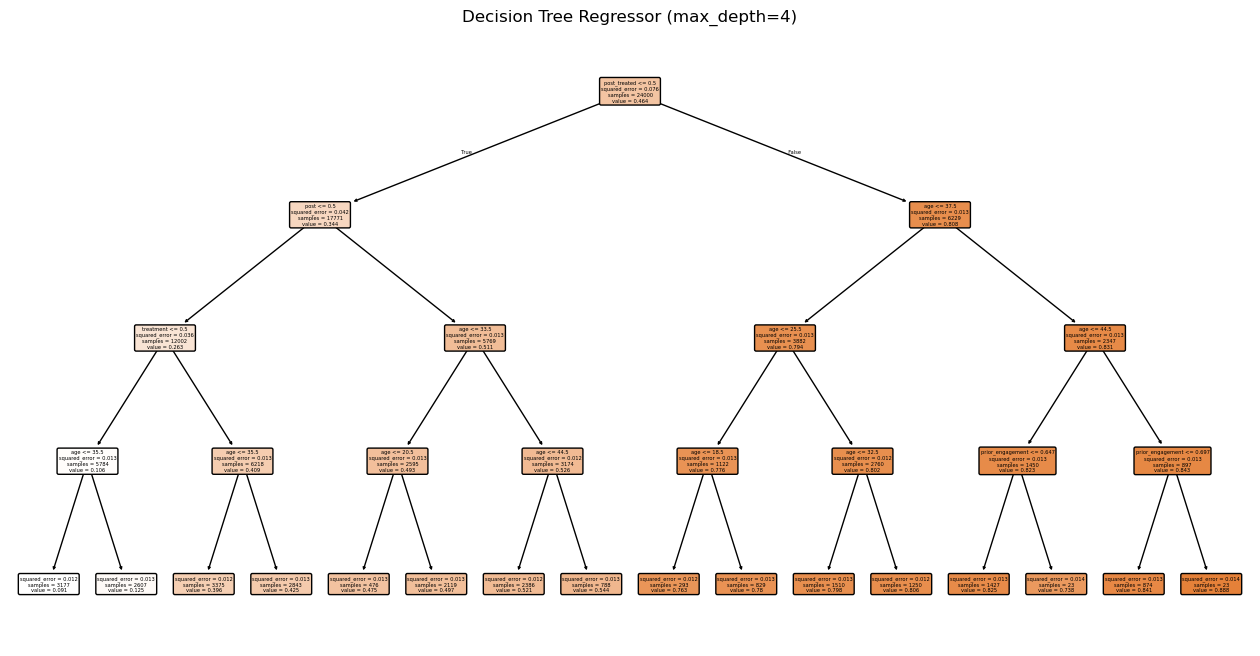


 Feature Importance:
         feature  importance
    post_treated    0.655051
       treatment    0.181270
            post    0.158359
             age    0.005174
prior_engagement    0.000145
       is_female    0.000000


In [12]:
# Plot tree
plt.figure(figsize=(16, 8))
plot_tree(model, feature_names=features, filled=True, rounded=True)
plt.title("Decision Tree Regressor (max_depth=4)")
plt.show()

# Feature importance
importance_df = pd.DataFrame({
    "feature": features,
    "importance": model.feature_importances_
}).sort_values("importance", ascending=False)

print("\n Feature Importance:")
print(importance_df.to_string(index=False))